In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
import datetime

<h1>Limpieza y filtrado de la data.<h1>

In [2]:
name = r"C:\Users\jibar\OneDrive - Universidad de los andes\Clases_Maestria\CIENCIA DE DATOS\Proyecto\General\General\Data\Daily.csv"

data =pd.read_csv(name,sep='|',error_bad_lines=False, warn_bad_lines= False,index_col=False,header=0, low_memory=False)

In [3]:
def eliminar_coma(x):
    x=str(x).replace(',','.')
    return x

In [4]:

data['VolUnCorrected']=data['VolUnCorrected'].apply(eliminar_coma)
data['VolCorrected']=data['VolCorrected'].apply(eliminar_coma)
data['Pressure']=data['Pressure'].apply(eliminar_coma)
data['Temperature']=data['Temperature'].apply(eliminar_coma)


convert = {'id_sitio':'object',
          'VolUnCorrected':float,
          'VolCorrected':float,
          'Pressure':float,
          'Temperature':float,
          'MaxPressure':float,
          'MinPressure':float,
          'MaxFlow':float,
          'MinFlow':float,
          'MaxTemp':float,
          'MinTemp':float,
          'id_RTU':'object'}
data = data.astype(convert)

In [5]:
selected = ['id_sitio','Daily_Date','VolUnCorrected',
       'VolCorrected', 'Pressure', 'Temperature']
data  = data[selected]

In [6]:
data.drop_duplicates(inplace=True)
data.dropna(inplace=True)

In [7]:
data['Daily_Date']   = pd.to_datetime(data['Daily_Date'])
data['Day'] =data['Daily_Date'].dt.date
lista = list(range(151,170))
data1 = data[data['id_sitio'].isin(lista)]

lista = [153, 154, 157, 160, 165, 167]
data1 = data[data['id_sitio'].isin(lista)]
grupo1 = data1.copy()

lista = [151, 152, 155, 156, 158, 159, 161, 162, 163, 164, 166, 168, 169, 170]
data1 = data[data['id_sitio'].isin(lista)]
grupo2 = data1.copy()

<h1> Etiquetado<h1>

In [8]:
grupo2

,id_sitio,Daily_Date,VolUnCorrected,VolCorrected,Pressure,Temperature,Day
127,151,2013-08-22 23:59:59,1228.00,20478.64,231.00,27.00,2013-08-22
128,152,2013-08-22 23:59:59,981.00,16091.16,227.00,27.00,2013-08-22
131,155,2013-08-22 23:59:59,1056.01,17570.78,230.00,26.00,2013-08-22
132,156,2013-08-22 23:59:59,791.93,13256.85,233.00,26.00,2013-08-22
134,158,2013-08-22 23:59:59,1091.98,17638.21,224.00,27.00,2013-08-22
...,...,...,...,...,...,...,...
396767,161,2018-01-22 23:59:59,2581.70,43405.62,191.15,9.58,2018-01-22
396768,162,2018-01-22 23:59:59,1295.42,21777.57,117.72,12.23,2018-01-22
396769,163,2018-01-22 23:59:59,1102.33,18881.58,118.55,12.31,2018-01-22
396770,164,2018-01-22 23:59:59,2068.11,33963.35,114.95,13.32,2018-01-22


In [9]:
mapa = grupo2['id_sitio']==151
inst = grupo2[mapa].copy()
day = inst['Day']
daily =inst['Daily_Date'] 
inst.drop(['id_sitio','Day'],axis = 1,inplace = True)
scaler = StandardScaler()
stan = scaler.fit_transform(inst.drop(['Daily_Date'], axis = 1))

datframe = pd.DataFrame(data=stan,columns=inst.drop(['Daily_Date'],axis = 1).columns)
datframe['Daily_Date'] = daily.reset_index(drop=True)

datframe.sort_values(by='Daily_Date',inplace = True)
datframe.reset_index(inplace=True,drop=True)



<h3> datos superiores a 2 std</h3>

In [10]:
datframe['Mayor_2std'] = (datframe['VolUnCorrected']>2) | (datframe['VolUnCorrected']<-2)

<h3>Datos que tiene 3 datos consecutivos anteriores o posteriores</h3>

In [11]:

consecutivos = 3
lista =[]


for i in range(0,datframe.index.max()+1):
    if i<3:
        adelante = (datframe['VolUnCorrected'].iloc[i:i+consecutivos].mean()==datframe['VolUnCorrected'].iloc[i].mean())
        lista.append(adelante)
    elif i>datframe.index.max()-3:
        atras = (datframe['VolUnCorrected'].iloc[i-consecutivos:i].mean()==datframe['VolUnCorrected'].iloc[i].mean())
        lista.append(atras)
    else :
        atras = (datframe['VolUnCorrected'].iloc[i-consecutivos:i].mean()==datframe['VolUnCorrected'].iloc[i].mean())
        adelante = (datframe['VolUnCorrected'].iloc[i:i+consecutivos].mean()==datframe['VolUnCorrected'].iloc[i].mean())
        consecutivo= atras | adelante
        lista.append(consecutivo)
datframe['Consecutivo']=lista


<h3> Determinacion de Falla<h3>

In [12]:
datframe['Falla']=(datframe['Mayor_2std'] & datframe['Consecutivo'])


<h3>Ventana prediccion</h3>

In [13]:
lista = []
ventana =30
for i in range(0,datframe.index.max()+1):
    if datframe.index.max()-(ventana-1)>i:
        lista.append(datframe['Falla'].iloc[i:i+ventana].any())
    else :
        lista.append(False)
datframe['Predictor']=lista


<h3> Solo elementos ants de la falla<h3>

In [14]:
datframe['SoloAntes']=(datframe['Falla'] ^ datframe['Predictor'])


In [15]:
datframe['FallaNum'] = datframe['Falla'].map({True:3,False:0})
datframe['PredictorNum'] = datframe['Predictor'].map({True:2,False:0})
datframe['SoloAntesNum'] = datframe['SoloAntes'].map({True:1,False:0})

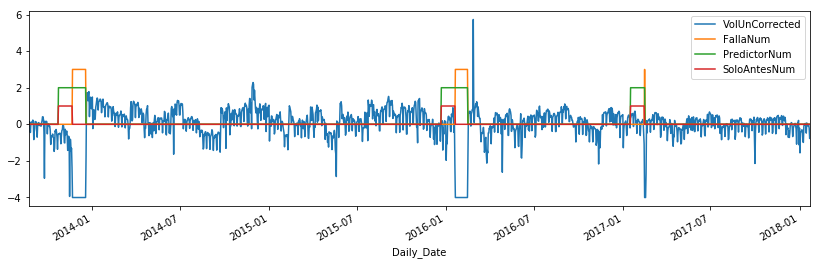

In [16]:
datframe.set_index(keys='Daily_Date')[['VolUnCorrected','FallaNum', 'PredictorNum','SoloAntesNum']].plot(figsize = (14,4))

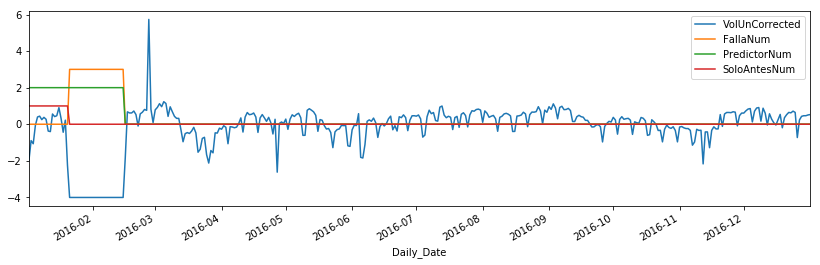

In [17]:
fecha ='2016'
fig=datframe.set_index(keys='Daily_Date')[fecha][['VolUnCorrected','FallaNum', 'PredictorNum','SoloAntesNum']].plot(figsize = (14,4))


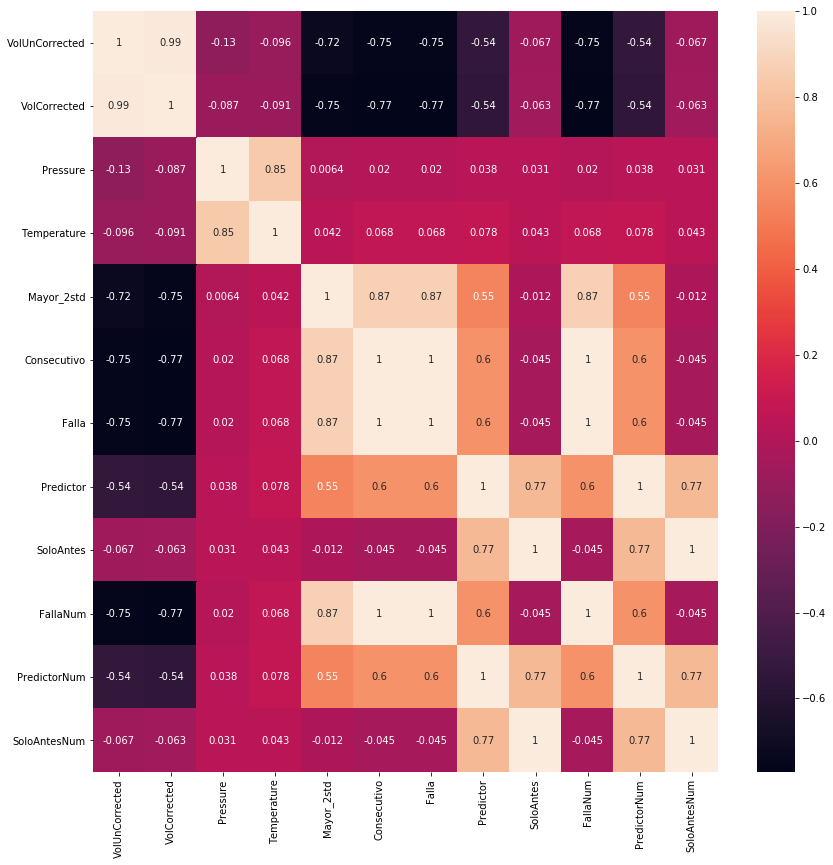

In [18]:
import seaborn as sn
plt.figure(figsize=(14,14))
sn.heatmap(datframe.corr(method='pearson'),annot=True)

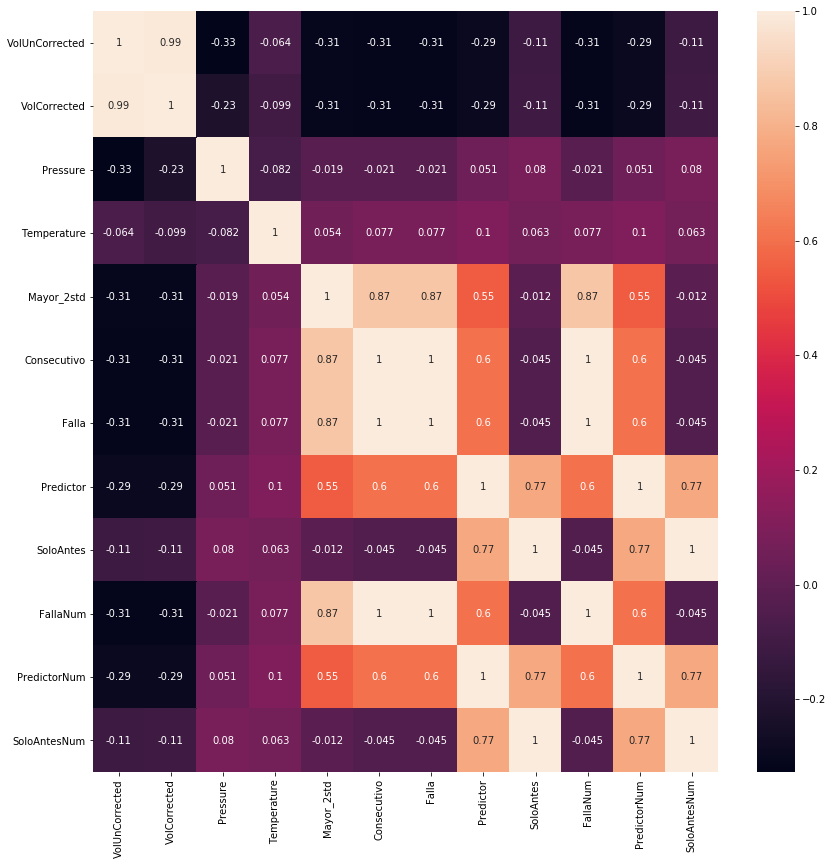

In [19]:
import seaborn as sn
plt.figure(figsize=(14,14))
sn.heatmap(datframe.corr(method='spearman'),annot=True)

In [20]:
# primera aproximacion trabajar todas estas lineas com osi fueran la misma. en ese sentido se genera una matriz en donde estan todas las caracteristicas.

In [21]:
    ### Condiciones
def etiquetado(data=grupo2 ,id_sitio = 151, cons =3, std=2, vent =30):
        mapa = grupo2['id_sitio']==id_sitio # que sitio 
        consecutivos = cons # condicion para valores repetidos seguidos infdicador de falla
        stds =std #Condicion de deviaciones estandart para identificador de falla (picos)
        ventana =vent # Ventana de prediccion



        inst = data[mapa].copy()
        day = inst['Day']
        daily =inst['Daily_Date'] 
        ids = inst['id_sitio'].copy()
        inst.drop(['id_sitio','Day'],axis = 1,inplace = True)
        scaler = StandardScaler()
        stan = scaler.fit_transform(inst.drop(['Daily_Date'], axis = 1))

        datframe = pd.DataFrame(data=stan,columns=inst.drop(['Daily_Date'],axis = 1).columns)
        datframe['Daily_Date'] = daily.reset_index(drop=True)
        datframe['id_sitio'] = ids.reset_index(drop=True)
        
        datframe.sort_values(by='Daily_Date',inplace = True)
        datframe.reset_index(inplace=True,drop=True)


        datframe['Mayor_2std'] = (datframe['VolUnCorrected']>stds) | (datframe['VolUnCorrected']<-stds)



        lista =[]


        for i in range(0,datframe.index.max()+1):
            if i<3:
                adelante = (datframe['VolUnCorrected'].iloc[i:i+consecutivos].mean()==datframe['VolUnCorrected'].iloc[i].mean())
                lista.append(adelante)
            elif i>datframe.index.max()-3:
                atras = (datframe['VolUnCorrected'].iloc[i-consecutivos:i].mean()==datframe['VolUnCorrected'].iloc[i].mean())
                lista.append(atras)
            else :
                atras = (datframe['VolUnCorrected'].iloc[i-consecutivos:i].mean()==datframe['VolUnCorrected'].iloc[i].mean())
                adelante = (datframe['VolUnCorrected'].iloc[i:i+consecutivos].mean()==datframe['VolUnCorrected'].iloc[i].mean())
                consecutivo= atras | adelante
                lista.append(consecutivo)
        datframe['Consecutivo']=lista

        datframe['Falla']=(datframe['Mayor_2std'] & datframe['Consecutivo'])


        lista = []

        for i in range(0,datframe.index.max()+1):
            if datframe.index.max()-(ventana-1)>i:
                lista.append(datframe['Falla'].iloc[i:i+ventana].any())
            else :
                lista.append(False)
        datframe['Predictor']=lista

        datframe['SoloAntes']=(datframe['Falla'] ^ datframe['Predictor'])

        datframe['FallaNum'] = datframe['Falla'].map({True:3,False:0})
        datframe['PredictorNum'] = datframe['Predictor'].map({True:2,False:0})
        datframe['SoloAntesNum'] = datframe['SoloAntes'].map({True:1,False:0})
        return datframe

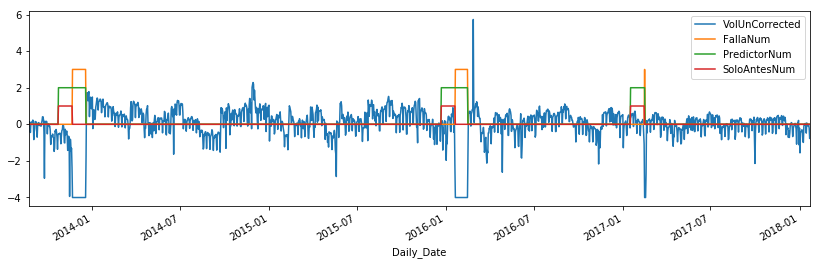

In [22]:
sal = etiquetado(id_sitio=151)
sal.set_index(keys='Daily_Date')[['VolUnCorrected','FallaNum', 'PredictorNum','SoloAntesNum']].plot(figsize = (14,4))

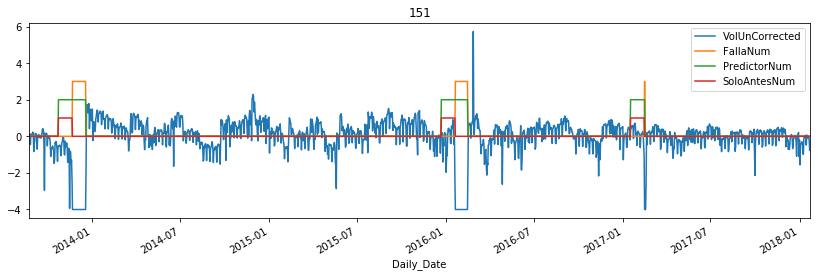

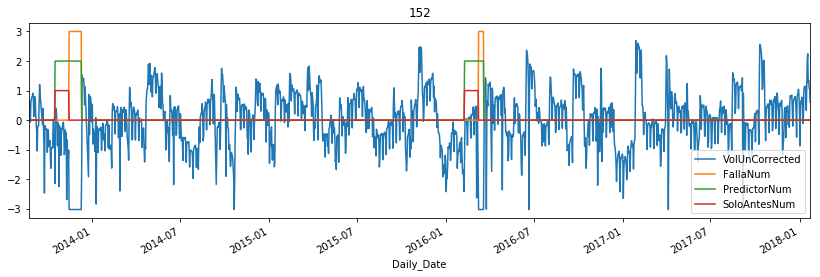

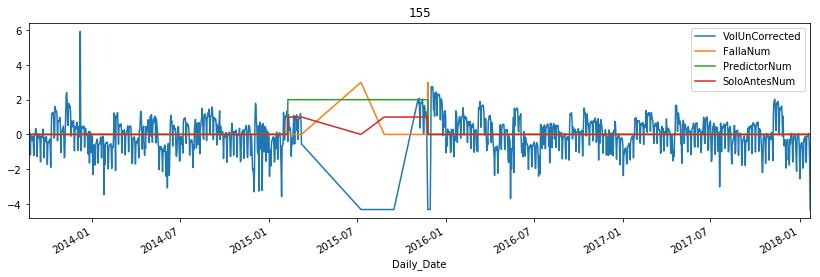

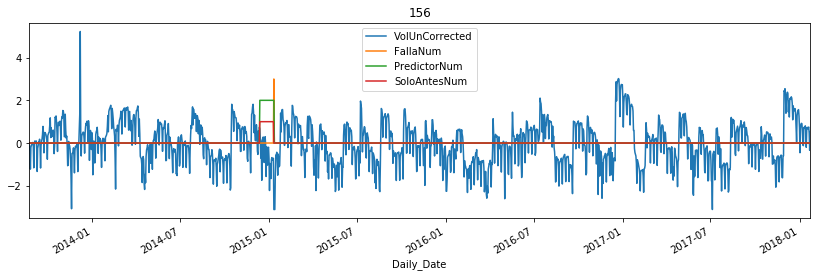

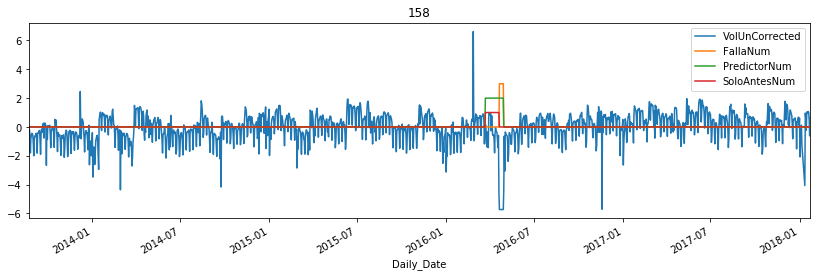

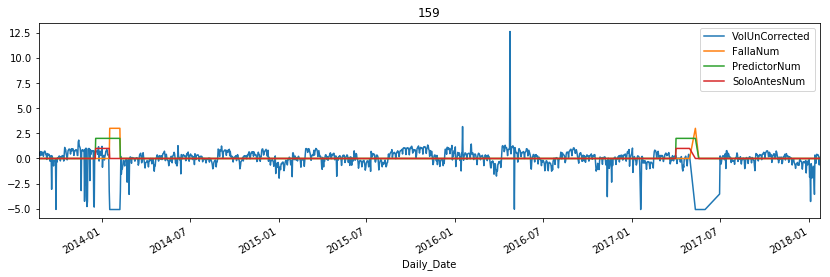

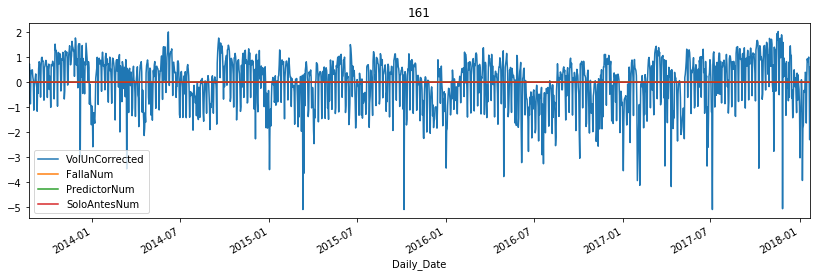

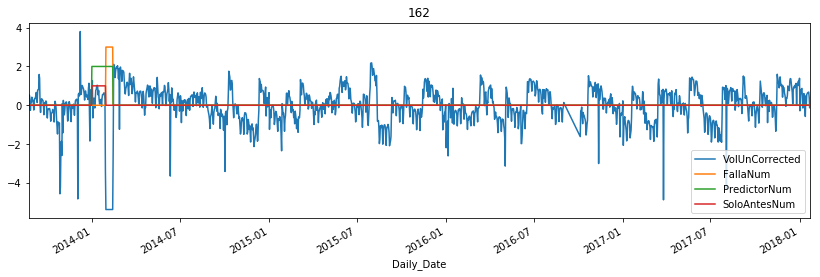

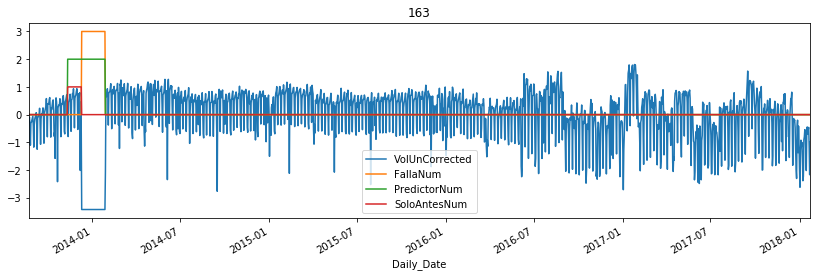

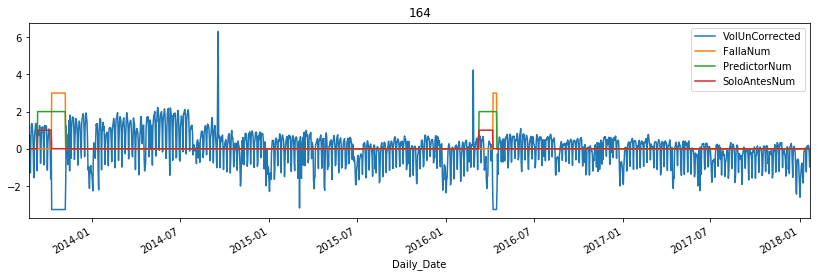

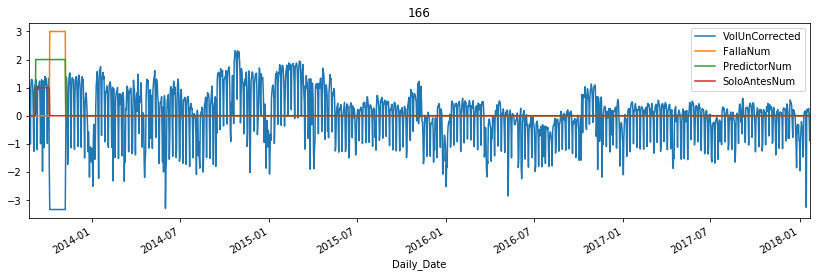

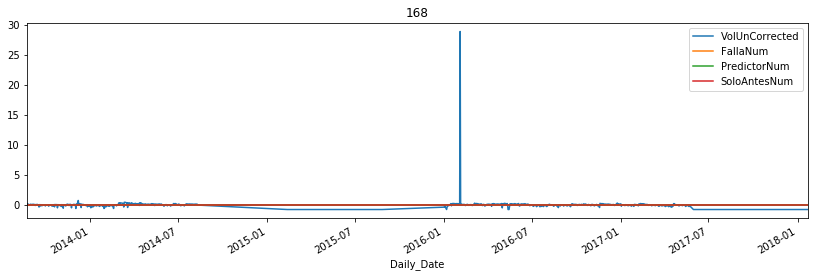

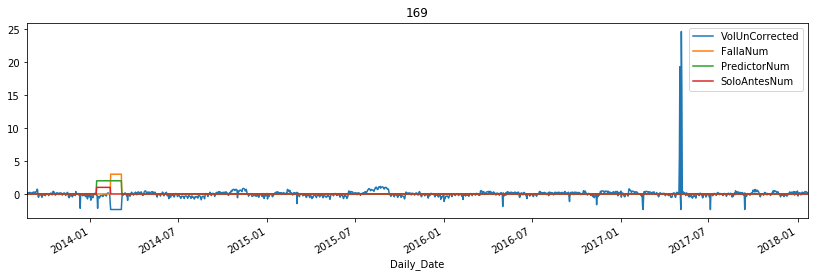

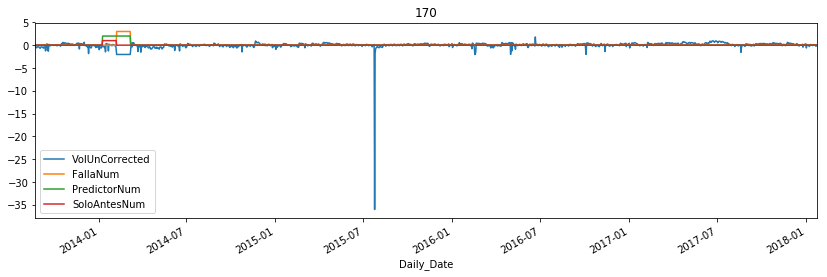

In [23]:
for i in grupo2['id_sitio'].unique():
    
    sal = etiquetado(id_sitio=i)
    
    fig = sal.set_index(keys='Daily_Date')[['VolUnCorrected','FallaNum', 'PredictorNum','SoloAntesNum']].plot(figsize = (14,4))
    fig.set_title(i)
#     plt.show()

Se eliminaran estaciones 155 y 168 por falta importante de datos.(es observable u cuentan con menos registros y que estos presnetan huecos grndes de data).

<h3> Generacion de caracteristicas</h3>

In [24]:
# Calcular antes las caracterisicas y despues si juntar los datos.

sal = etiquetado(id_sitio=i)
data_etiquetada = pd.DataFrame(columns=sal.columns)
ids = grupo2['id_sitio'].unique().tolist()
if (155 in ids) and (168 in ids):
    ids.remove(155)
    ids.remove(168)
for i in ids:
    sal = etiquetado(id_sitio=i)
    
    ## aquie genercion de carcateristicas.
    
    data_etiquetada=data_etiquetada.append(sal, ignore_index = True)

    


In [25]:
sal.columns

Index(['VolUnCorrected', 'VolCorrected', 'Pressure', 'Temperature',
       'Daily_Date', 'id_sitio', 'Mayor_2std', 'Consecutivo', 'Falla',
       'Predictor', 'SoloAntes', 'FallaNum', 'PredictorNum', 'SoloAntesNum'],
      dtype='object')

In [26]:
ventana = 30

new_characteristics = pd.DataFrame()
count=0
for i in range(ventana,sal.index.max()+1):
    count+=1
    caracteriticas =['media', 'mediana','std']

    
    timestep = sal.iloc[i-ventana:i]
    
    media = timestep.mean()
    
    mediana = timestep.median()
    
    desviacion = timestep.std()
    

    Dmediana = {i:j for i, j in zip(mediana.index,('Mediana_'+mediana.index))}
    
    Dmedia = {i:j for i, j in zip(mediana.index,('Media_'+media.index))}
    
    Ddesviacion = {i:j for i, j in zip(desviacion.index,('Media_'+desviacion.index))}
        
    mediana.rename(Dmediana, inplace = True)
    media.rename(Dmedia, inplace = True)  
    desviacion.rename(Ddesviacion , inplace = True) 
    
    med = pd.DataFrame(media).transpose()
    mian=pd.DataFrame(mediana).transpose()
    desv = pd.DataFrame(desviacion).transpose()
    actual = (pd.DataFrame(sal.iloc[i]).transpose()).reset_index()
    
    
#     new_characteristics = new_characteristics.append(pd.concat([med,mian,desv,actual],axis = 1))
    # Hasta aca funciona sin lo siguiente.
    
    primeras = pd.concat([med,mian,desv,actual],axis = 1)
    for i in range(29,0,-1):
        newVol = '{} Dias_antesVol'.format(i)
        newTemp = '{} Dias_antesTemp'.format(i)
        newVPres = '{} Dias_antesPres'.format(i)
        names_list =[]
        value_list=[]
        names_list.append(newVol)
        names_list.append(newTemp)
        names_list.append(newVPres)
        
#         names_list=[newVol,newTemp,newVPres]
        
        value_list.append([timestep.iloc[30-i]['VolUnCorrected']])
        value_list.append([timestep.iloc[30-i]['Temperature']])
        value_list.append([timestep.iloc[30-i]['Pressure']])
#         value_list=[timestep.iloc[30-i]['VolUnCorrected'],timestep.iloc[30-i]['Temperature'],timestep.iloc[30-i]['Pressure']]
        

        segundas =pd.DataFrame(data=value_list,index=names_list)

        primeras = pd.concat([primeras,segundas.transpose()],axis = 1)
#         new_characteristics[newVol]=ventana[30-i]['VolUnCorrected']
#         new_characteristics[newTemp]=ventana[30-i]['Temperature']
#         dias[newPres]=ventana[30-i]['Pressure']
    new_characteristics = new_characteristics.append(pd.concat([actual,med,mian,desv,primeras],axis = 1))

In [27]:
new_characteristics.columns

Index(['index', 'VolUnCorrected', 'VolCorrected', 'Pressure', 'Temperature',
       'Daily_Date', 'id_sitio', 'Mayor_2std', 'Consecutivo', 'Falla',
       ...
       '4 Dias_antesPres', '3 Dias_antesVol', '3 Dias_antesTemp',
       '3 Dias_antesPres', '2 Dias_antesVol', '2 Dias_antesTemp',
       '2 Dias_antesPres', '1 Dias_antesVol', '1 Dias_antesTemp',
       '1 Dias_antesPres'],
      dtype='object', length=195)

In [31]:
ids = grupo2['id_sitio'].unique().tolist()
data_etiquetada = pd.DataFrame()
if (155 in ids) and (168 in ids):
    ids.remove(155)
    ids.remove(168)
for i in ids:
    ventana = 30
    sal = etiquetado( data=grupo2 ,id_sitio = i, cons =3, std=2, vent =ventana)
    
  
    ## aquie genercion de carcateristicas.
    
    

    

    new_characteristics = pd.DataFrame()
    count=0
    for i in range(ventana,sal.index.max()+1):
        count+=1
        caracteriticas =['media', 'mediana','std']


        timestep = sal.iloc[i-ventana:i]

        media = timestep.mean()

        mediana = timestep.median()

        desviacion = timestep.std()


        Dmediana = {i:j for i, j in zip(mediana.index,('Mediana_'+mediana.index))}

        Dmedia = {i:j for i, j in zip(mediana.index,('Media_'+media.index))}

        Ddesviacion = {i:j for i, j in zip(desviacion.index,('Media_'+desviacion.index))}

        mediana.rename(Dmediana, inplace = True)
        media.rename(Dmedia, inplace = True)  
        desviacion.rename(Ddesviacion , inplace = True) 

        med = pd.DataFrame(media).transpose()
        mian=pd.DataFrame(mediana).transpose()
        desv = pd.DataFrame(desviacion).transpose()
        actual = (pd.DataFrame(sal.iloc[i]).transpose()).reset_index()


    #     new_characteristics = new_characteristics.append(pd.concat([med,mian,desv,actual],axis = 1))
        # Hasta aca funciona sin lo siguiente.

        primeras = pd.concat([med,mian,desv,actual],axis = 1)
        for i in range(29,0,-1):
            newVol = '{} Dias_antesVol'.format(i)
            newTemp = '{} Dias_antesTemp'.format(i)
            newVPres = '{} Dias_antesPres'.format(i)
            names_list =[]
            value_list=[]
            names_list.append(newVol)
            names_list.append(newTemp)
            names_list.append(newVPres)

    #         names_list=[newVol,newTemp,newVPres]

            value_list.append([timestep.iloc[30-i]['VolUnCorrected']])
            value_list.append([timestep.iloc[30-i]['Temperature']])
            value_list.append([timestep.iloc[30-i]['Pressure']])
    #         value_list=[timestep.iloc[30-i]['VolUnCorrected'],timestep.iloc[30-i]['Temperature'],timestep.iloc[30-i]['Pressure']]


            segundas =pd.DataFrame(data=value_list,index=names_list)

            primeras = pd.concat([primeras,segundas.transpose()],axis = 1)
    #         new_characteristics[newVol]=ventana[30-i]['VolUnCorrected']
    #         new_characteristics[newTemp]=ventana[30-i]['Temperature']
    #         dias[newPres]=ventana[30-i]['Pressure']
        new_characteristics = new_characteristics.append(pd.concat([actual,med,mian,desv,primeras],axis = 1))    

    
    
    
    data_etiquetada=data_etiquetada.append(new_characteristics, ignore_index = True)

    

In [32]:
data_etiquetada

,index,VolUnCorrected,VolCorrected,Pressure,Temperature,Daily_Date,id_sitio,Mayor_2std,Consecutivo,Falla,...,4 Dias_antesPres,3 Dias_antesVol,3 Dias_antesTemp,3 Dias_antesPres,2 Dias_antesVol,2 Dias_antesTemp,2 Dias_antesPres,1 Dias_antesVol,1 Dias_antesTemp,1 Dias_antesPres
0,30,-0.405585,-0.301458,0.487702,-0.250344,2013-09-22 23:59:59,151,False,False,False,...,0.002996,0.408908,-0.250344,0.063584,0.412212,-0.250344,0.002996,0.261704,-0.250344,0.124173
1,31,-2.95057,-2.99979,0.366526,-0.250344,2013-09-23 23:59:59,151,True,False,False,...,0.063584,0.412212,-0.250344,0.002996,0.261704,-0.250344,0.124173,-0.405585,-0.250344,0.487702
2,32,0.168606,0.158374,0.00299596,-0.250344,2013-09-24 23:59:59,151,False,False,False,...,0.002996,0.261704,-0.250344,0.124173,-0.405585,-0.250344,0.487702,-2.950570,-0.250344,0.366526
3,33,0.138969,0.144922,0.0635842,-0.250344,2013-09-25 23:59:59,151,False,False,False,...,0.124173,-0.405585,-0.250344,0.487702,-2.950570,-0.250344,0.366526,0.168606,-0.250344,0.002996
4,34,0.0621947,0.0582481,0.0635842,-0.250344,2013-09-26 23:59:59,151,False,False,False,...,0.487702,-2.950570,-0.250344,0.366526,0.168606,-0.250344,0.002996,0.138969,-0.250344,0.063584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18882,1605,0.0610236,0.0612883,0.0195412,-0.65152,2018-01-18 23:59:59,170,False,False,False,...,0.227612,0.069792,-0.619191,0.035186,0.122622,-0.629968,-0.007576,0.067594,-10.813612,-5.908118
18883,1606,0.0345866,0.032289,0.00128945,-0.65152,2018-01-19 23:59:59,170,False,False,False,...,0.035186,0.122622,-0.629968,-0.007576,0.067594,-10.813612,-5.908118,0.061024,-0.651520,0.019541
18884,1607,-0.0688538,-0.0603283,0.0560448,-0.658705,2018-01-20 23:59:59,170,False,False,False,...,-0.007576,0.067594,-10.813612,-5.908118,0.061024,-0.651520,0.019541,0.034587,-0.651520,0.001289
18885,1608,-0.249298,-0.210937,0.0560448,-0.590454,2018-01-21 23:59:59,170,False,False,False,...,-5.908118,0.061024,-0.651520,0.019541,0.034587,-0.651520,0.001289,-0.068854,-0.658705,0.056045


In [38]:
data_etiquetada.to_csv(r'datos_etiquetados_con_caracteristicas.csv')

In [35]:
ids.shape

AttributeError: 'list' object has no attribute 'shape'